In [2]:
library(repr)
options(repr.plot.width=7, repr.plot.height=4.5)

# eventEst.R

Some visual investigations into the distributions of sampled event latencies against estimated occurrences (using the Shaft technique) What does the sampled event stream tell about how feequently things are actually happening, given that the sampler is biased to longer latencies?

## Environment
Do the usual package loads and ashDF data frame creation.

In [23]:
#install.packages("~/Desktop/Professional/Dev/ASHviz/ashdat_0.1.0.tar.gz", repos = NULL)
install.packages("./ashdat_0.1.0.tar.gz", repos = NULL)

library(ashdat)
library(dplyr)
library(ggplot2)

ashDF <- ashdat::STMAIL

## Events data frame
This notebook focuses on event latencies so the data frame Events is ashDF filtered for waits only. Filtering for `TIME_WAITED > 0` selects samples with values updated by the **ASH fix-up mechanism**. It's also worth noting that only the final sample row will be selected for very long events that may have been sampled multiple times, as only this row has the `TIME_WAITED` fixed up.

In [4]:
Events <- ashDF %>% filter( TIME_WAITED > 0 )

## Sampled event latency distributions
We start by using box-whisket plots to get insight into the distributions of event latencies, broken out by wait class and event.

## geom_boxplot ( )
Boxplots can be used to characterize and compare the sampled latency distributions.

Boxplot using aesthetic `y = log10(TIME_WAITED)` over all sampled events to get big picture of event latencies. Since `TIME_WAITED` is in microseconds, the values 3 and 6 correspond to 1 millisecond and 1 second respectively.

Note that the 50% box lies between 4 and 5.5 or so, meaning most sampled event latencies are between 10 and 300 or so milliseconds. Remember that the ASH sampler is biased to longer latencies; probability of being sampled is `( TIME_WAITED / 1000000 microsecs )` and therefore larger for longer events.

Also note a strong tail of observations below 100 microseconds that might be interesting to examine.

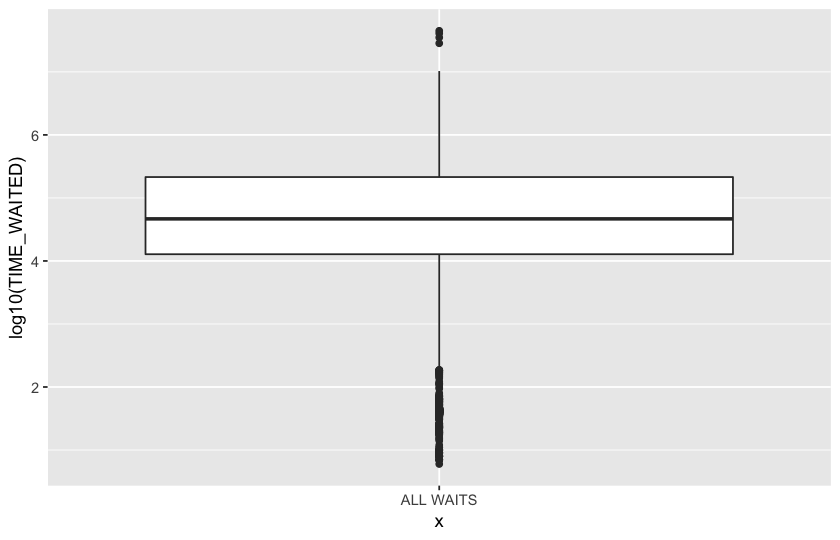

In [5]:
ggplot(data=Events, aes(x="ALL WAITS" ,y=log10(TIME_WAITED))) +
  geom_boxplot()

Adding the aesthetic `x = WAITCLASS` creates seperate box plots for each wait class, facilitating comparison across wait classes. Also, red intercepts are added at 1 sec and 1 millisecond for visual cross-reference.

We see that for all wait classes most sampled latencies are between 1 millisecond and 1 second. The *very* notable exception is the Idle class, notable both for minimal latency but also for being there at all given that Idle events are not supposed to be sampled into ASH (!?!)

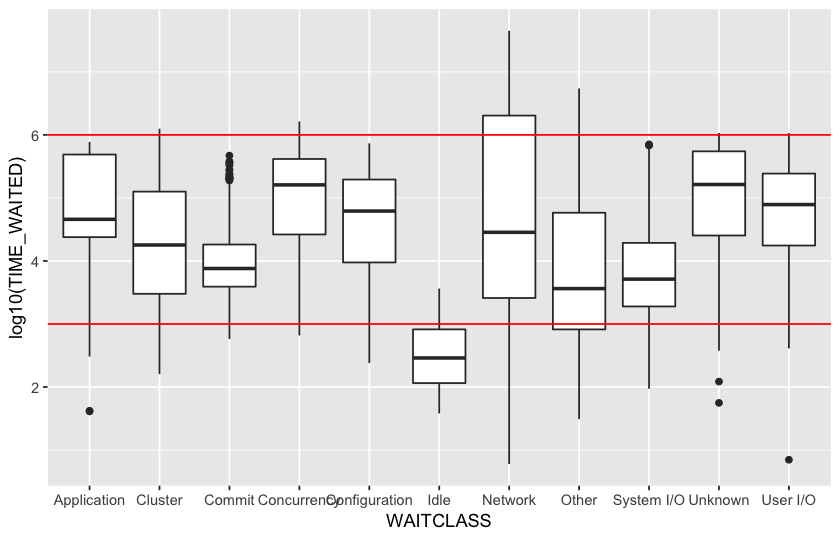

In [6]:
ggplot(data=Events, aes(x=WAITCLASS ,y=log10(TIME_WAITED))) +
  geom_boxplot() + 
  geom_hline(yintercept=c(3,6),color="red")

So what happens if we use aesthetic `x = EVENT_ID`?

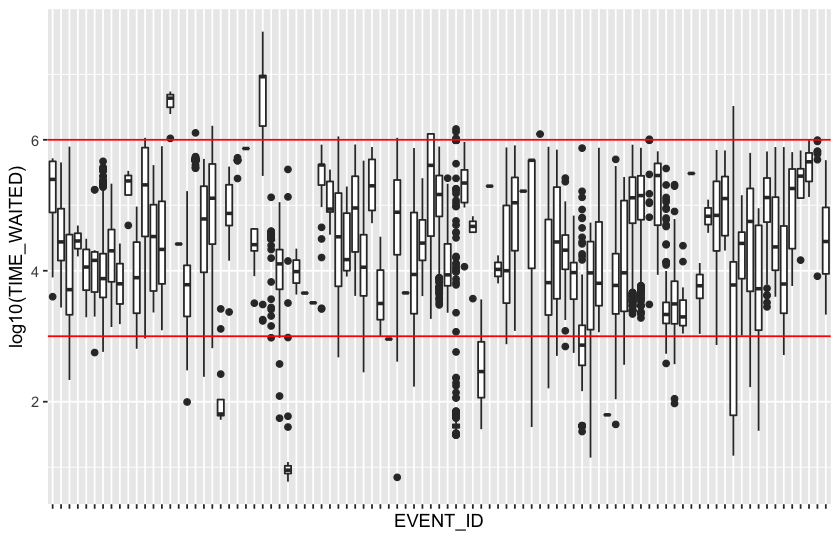

In [7]:
ggplot(data=Events, aes(x=EVENT_ID ,y=log10(TIME_WAITED))) +
  geom_boxplot() + 
  geom_hline(yintercept=c(3,6),color="red") + scale_x_discrete(labels=NULL)

How about adding to the mess with `color = WAITCLASS`? Ouch, that hurts.

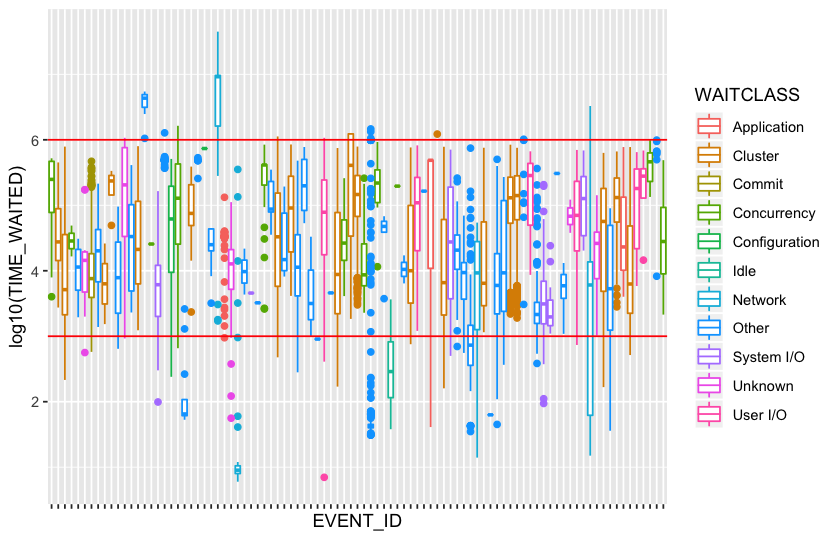

In [8]:
ggplot(data=Events %>% group_by(WAITCLASS), aes(x=EVENT_ID ,y=log10(TIME_WAITED))) +
  geom_boxplot(aes(color=WAITCLASS)) + 
  geom_hline(yintercept=c(3,6),color="red") + scale_x_discrete(labels=NULL)

Maybe if the event boxplots were arranged by event within wait class it would look better? In the code below the key is computing `NEW_ID` for the x-axis as the `paste` of wait class name and event name.

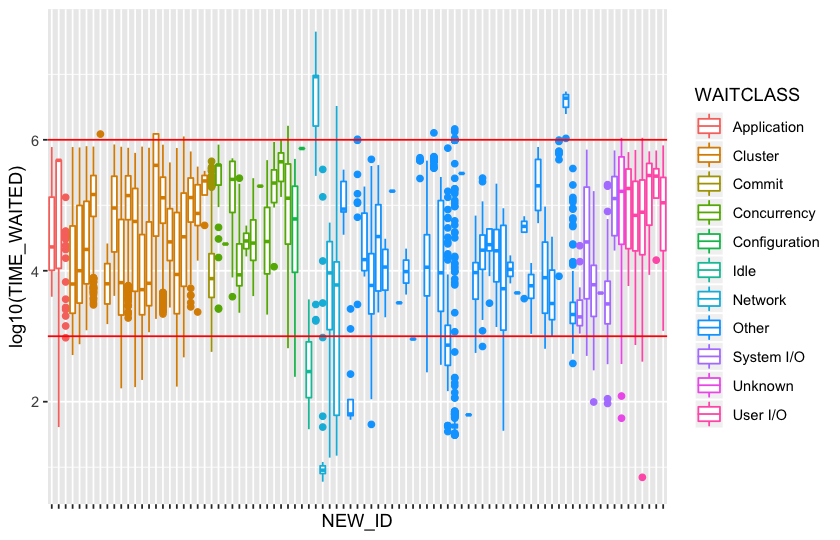

In [9]:
ggplot(data = Events %>% as_tibble() %>% mutate(NEW_ID = paste(WAITCLASS,EVENTNAME, sep = '.') )
      ,aes( x = NEW_ID , y = log10( TIME_WAITED ) ) ) +
  geom_boxplot(aes( color = WAITCLASS ) ) + 
  geom_hline( yintercept = c(3,6), color = "red")  + scale_x_discrete( labels = NULL)

Even though this is much improved, the horizontal space is very crowded from so many box plots, making them difficult to read. And of course we can't print out all the `NEW_ID` values. So this is still not that useful.

We can use faceting to separate out events by wait class into separate mini-plots. Unfortunately, the boxes are squeezed even tighter, as each mini-plot tries renders the total event (x) axis. Visualization fail.

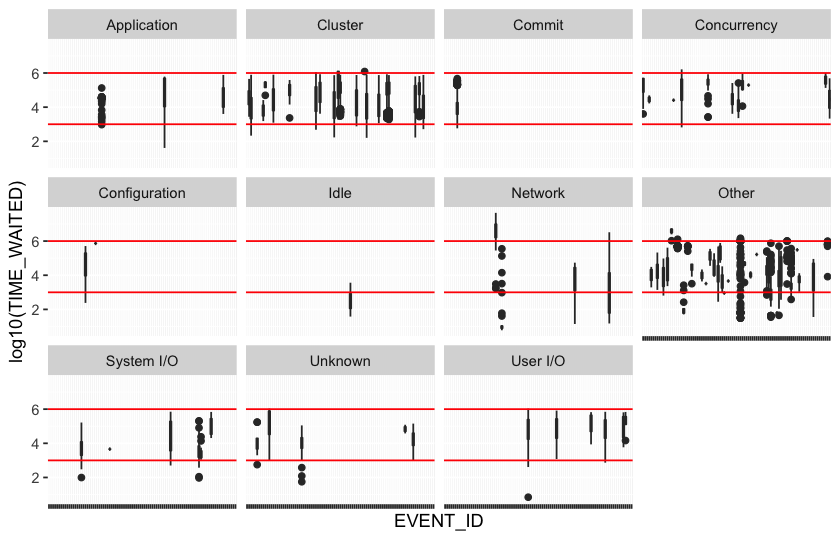

In [10]:
ggplot(data=Events %>% group_by(WAITCLASS), aes(x=EVENT_ID ,y=log10(TIME_WAITED))) +
  geom_boxplot() + facet_wrap(~WAITCLASS) +
  geom_hline(yintercept=c(3,6),color="red") + scale_x_discrete(labels=NULL)

When the x scale is freed in the faceted plots each wait class (facet) uses its full space to plot only events observed from that class. This allows the individual event boxplots to be as large as possible and still be grouped by wait class, and thus much more readable.

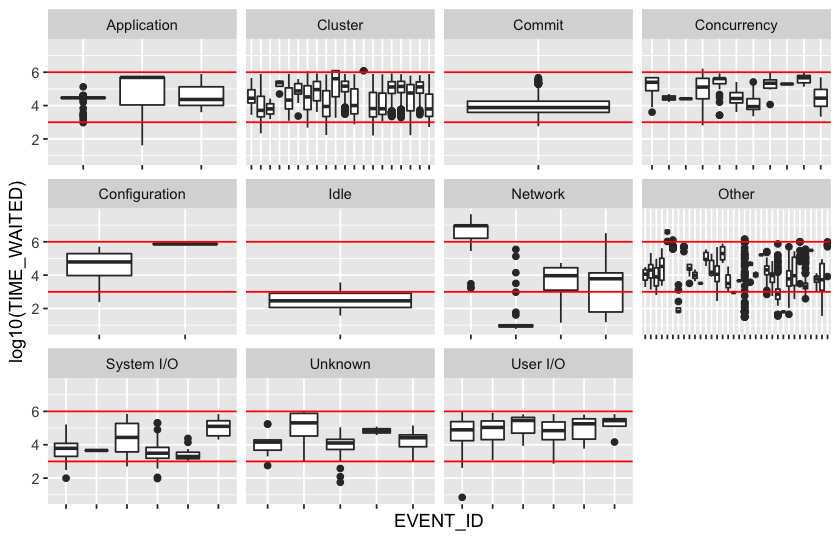

In [11]:
ggplot(data=Events %>% group_by(WAITCLASS), aes(x=EVENT_ID ,y=log10(TIME_WAITED))) +
  geom_boxplot() + facet_wrap(.~WAITCLASS, scales="free_x") +
  geom_hline(yintercept=c(3,6),color="red") + scale_x_discrete(labels=NULL)

What happens when we reverse the x and y variables in the aesthetic? My intuition would be horizontally oriented boxplots.

Wow, they didn't turn out at all like expected. They are even worse than the skinny vertical ones above. 

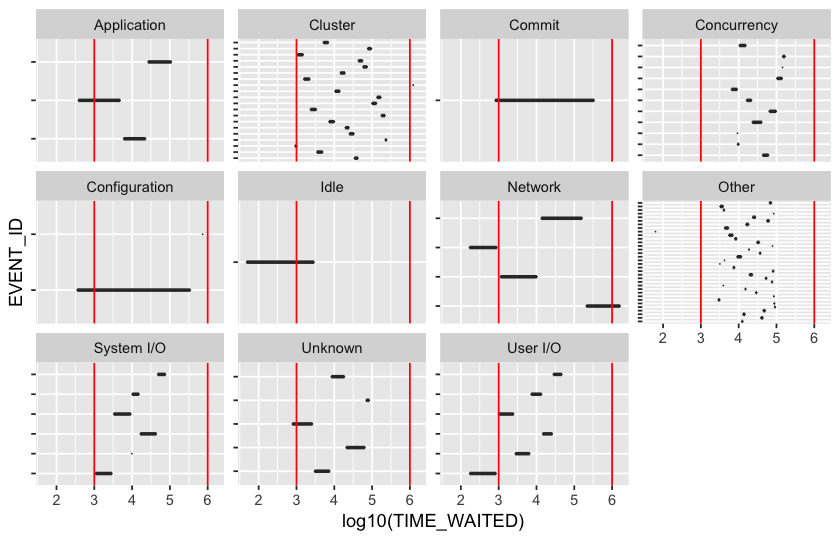

In [12]:
ggplot(data=Events %>% group_by(WAITCLASS), aes(y=EVENT_ID ,x=log10(TIME_WAITED))) +
  geom_boxplot() + facet_wrap(.~WAITCLASS, scales="free_y") +
  geom_vline(xintercept=c(3,6),color="red") + scale_y_discrete(labels=NULL)

It turns out that instead of reversing the aesthetic mappings for x and y, there is a much simpler way to turn a plot on its side using the `ggplot` function `coord_flip( )`. 

Appending a `ggplot2::coord_flip()` call to the earlier plot code does the job. No need to reverse x and y and change scaling calls. However, these plots seem much harder to read than vertical boxplots, so not really an improvement. 

(Good to know about `coord_flip()` though.)

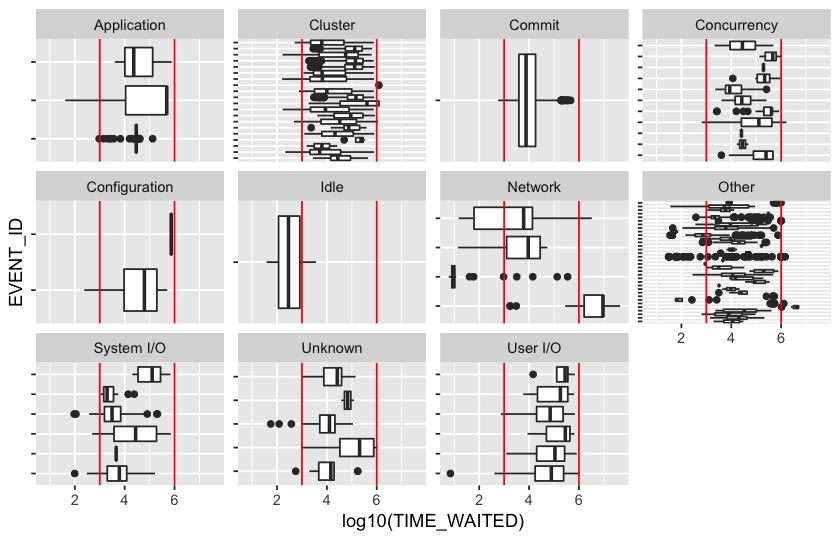

In [13]:
ggplot(data=Events %>% group_by(WAITCLASS), aes(x=EVENT_ID ,y=log10(TIME_WAITED))) +
  geom_boxplot() + facet_wrap(.~WAITCLASS, scales="free_y") +
  geom_hline(yintercept=c(3,6),color="red") + scale_x_discrete(labels=NULL) +
  ggplot2::coord_flip()

## geom_density( )
Density plots show a smooth probability distribution curve fitted to the sample data. We are interested in the distribution of event wait time latencies and plot densities for `x = log10(TIME_WAITED)`

Note the use of `qplot` instead of `ggplot` for initial experiments, for brevity only. In `qplot` the geom is specified as a parameter: `geom = c("density")`

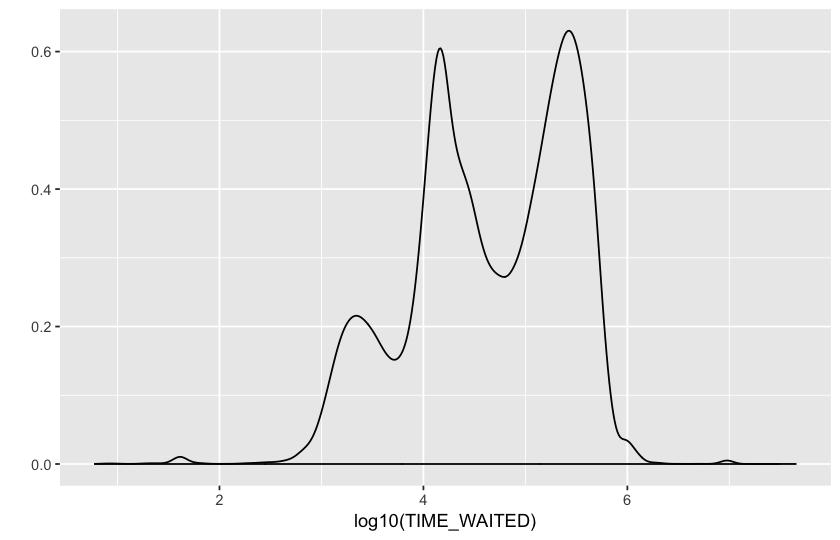

In [14]:
# use qplot and geom = c("density")
qplot(data = Events, x = log10(TIME_WAITED), geom = c("density"))

This plot exhibits three distinct peaks in the sample densities. The two highest of these and most of the probability are beteen 10 milliseconds and 1 second. However, these are *sampled* events, and the sampler is biased to longer events. So our collection of events is not independent of latency and thus does not represent the distribution of latencies fairly.

What if we are interested in the actual distribution of event latencies? Can we somehow undo the sampler bias and estimate what might actually be occurring from the sampled events?

## Estimating event occurrences
It turns out that we can use the samples to estimate the volume of actual event occurrences, and from that compute weighted probability density representations of the actual latency distributions. This is done using a technique developed and proven by Uri Shaft that makes intuitive sense. For an event sampled by a 1000000 microsecond (1 sec) sampling interval, divide 1000000 by `TIME_WAITED` if `TIME_WAITED < 1000000` and otherwise set it to 1. So if we sample a 500 millisecond event, it *counts* for 2. Similarly, a 10 millisecond event counts for 100. So the count estimate is the inverse of the probability of being sampled:
-       count: `<sampling interval> / TIME_WAITED`
- probability: `TIME_WAITED / <sampling interval>` 

The ash data frames in `ashdat` compute the estimated count for each sampled event as follows:
 
 `ashDF$EST_COUNT <- as.integer(dplyr::if_else(ashDF$TIME_WAITED >0 & ashDF$TIME_WAITED <1000000,
                                 round(1000000/ashDF$TIME_WAITED),1))`

I note a bug in the code above that samples with `TIME_WAITED = 0` (ON CPU samples and any non-terminal samples for very long waits) will get `EST_COUNT = 1`. However this does not affect our analysis as the `Events` data frame is filtered for `TIME_WAITED > 0`

We use the `weight` aesthetic in `geom_density( )` to assign each sample a weight proportional to the estimated count. 

For density plots the weights must sum to 1, so each sample is weighted by its proportion of the total estimated count: `weight = EST_COUNT / sum( EST_COUNT)`

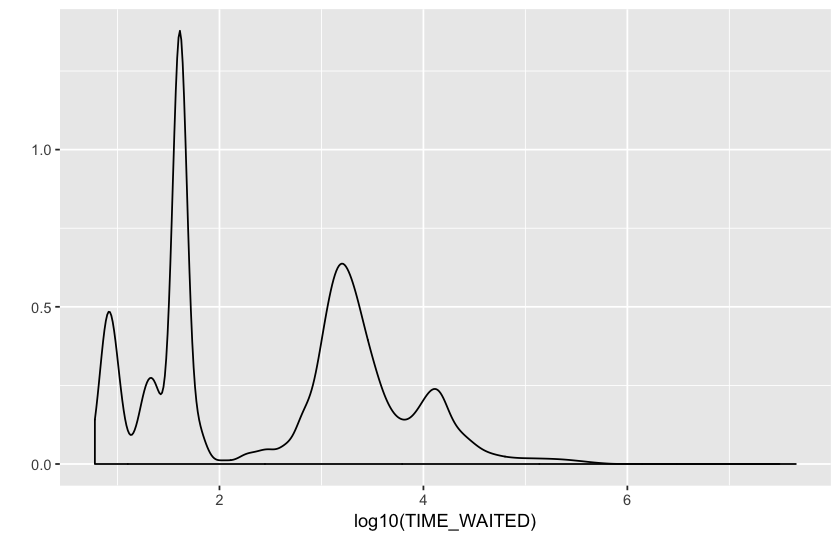

In [15]:
qplot(data = Events, x = log10(TIME_WAITED), geom = c("density")
     ,weight = EST_COUNT / sum( EST_COUNT ) )

The weighted density plot is vastly different from the sampled density. Most of the density is for latencies < 10 milliseconds, and a significant amount is less than 100 (= 10\*\*2) microseconds. We can see the effect of having sampled some very low-latency events, they get correspondingly high estimated counts. 

If we want to reason about how long wait events take in the system, using unweighted sampled latencies is a serious misrepresentation. Beware.

We plot the two together, coloring the sampled event count density in blue and tbe estimated event count density in red. This is done by adding separate `geom_density()` layers for each.

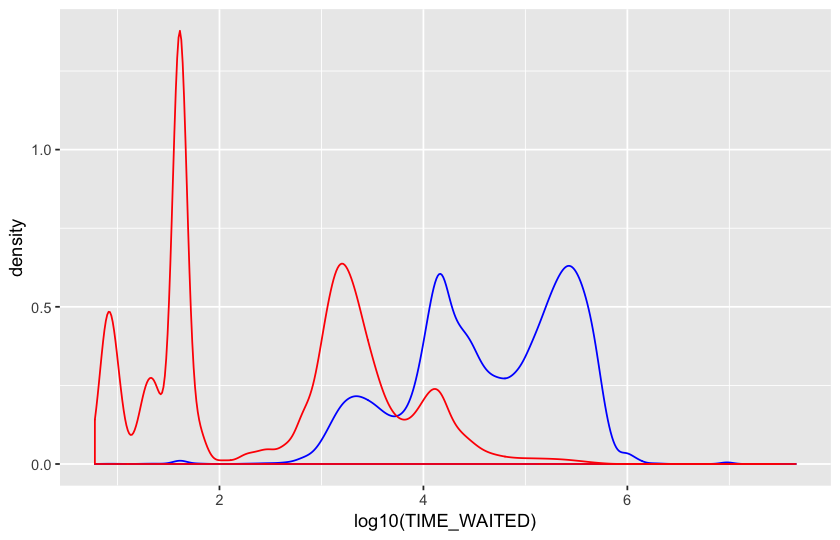

In [16]:
ggplot(data=Events, aes(x=log10(TIME_WAITED))) +
      geom_density(aes(color=I("blue"))) +
      geom_density(aes(color=I("red"),  weight=EST_COUNT/sum(EST_COUNT)))

Another visualization of density is called the "violin" plot. Basically it's the density plot folded over th x-axis and then flipped up vertically. The symmetry seems to enhance the undertandability. First let's plot the sampled latencies.

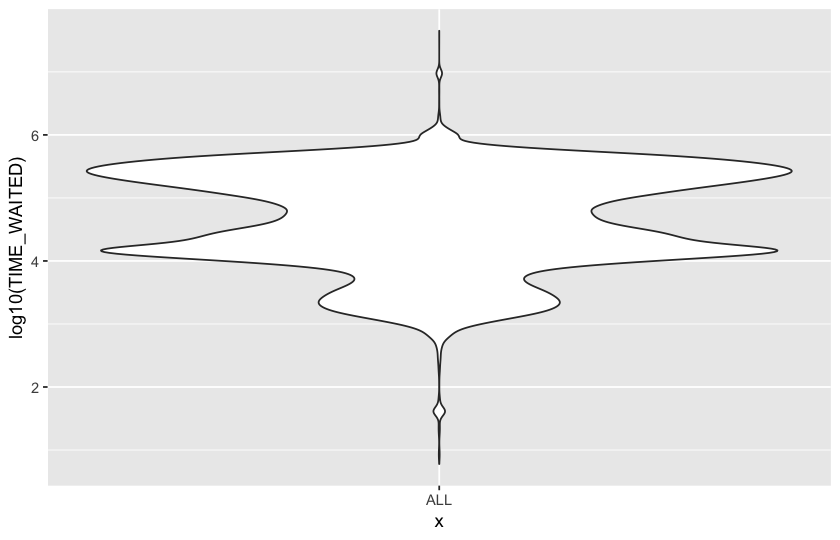

In [17]:
ggplot(data=Events, aes(x="ALL", y=log10(TIME_WAITED))) +
  geom_violin()

We can see the resemblance to the density plot earlier, the three peaks have become three "wings" sticking out to the side. The two little "blips" in the tails are interesting as well.

Specifying x = INSTANCE_NUMBER in the aesthetic produces a separate violin for each instance. Here the plot shape definitely helps with making comparison, the mind can recognize similarities and differences better.

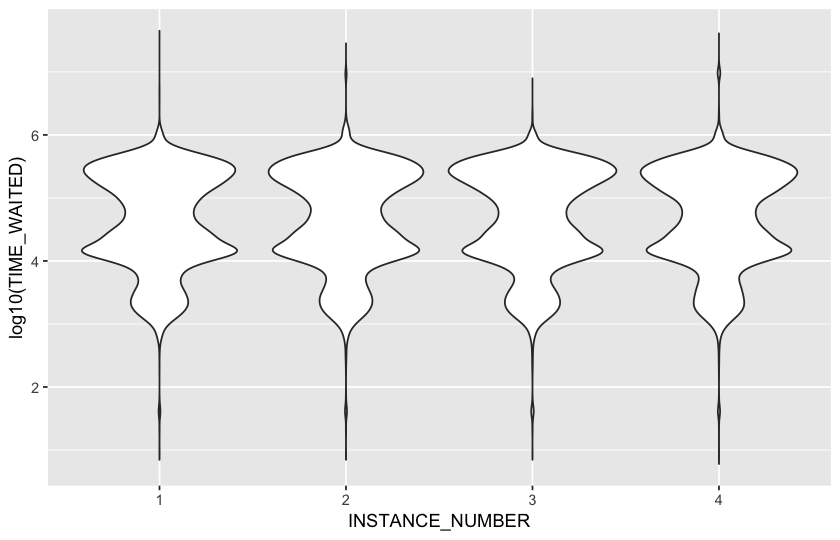

In [18]:
ggplot(data=Events, aes(x=INSTANCE_NUMBER, y=log10(TIME_WAITED))) +
  geom_violin()

`geom_violin( )` can be weighted with the estimated counts in the same way as `geom_density( )` to provide an adjusted picture of the inferred actual distribution of event latencies in the system. Again, we see how the estimated latency distribution is much expanded in the lower latencies.

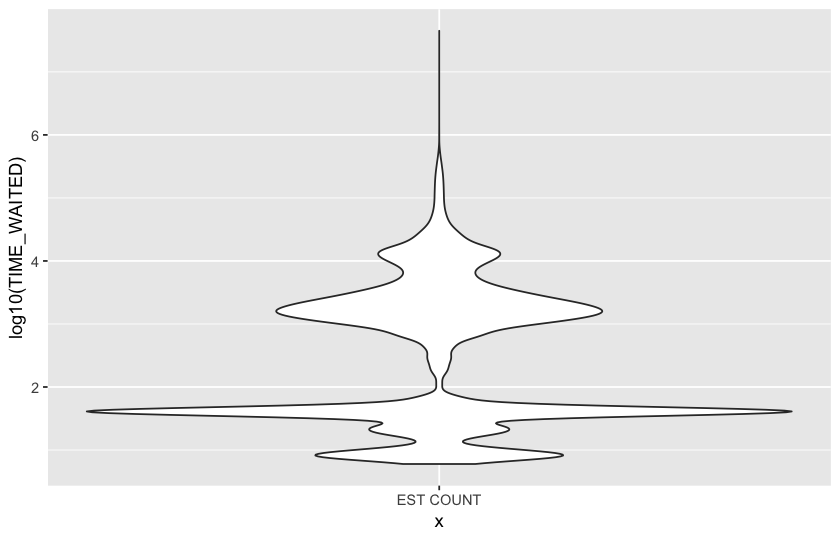

In [19]:
ggplot(data=Events, aes(x="EST COUNT", y=log10(TIME_WAITED))) +
  geom_violin(aes(weight=EST_COUNT/sum(EST_COUNT)))

Faceting by `INSTANCE_NUMBER` for comparison gives warning messages about the weights not summing to 1, but the violins seem to look OK. Changing the aesthetic to `weight = EST_COUNT / sum(EST_COUNT)` gives same warning and same violins. 

Something to figure out about it.

Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
“sum(weights) != 1  -- will not get true density”Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
“sum(weights) != 1  -- will not get true density”Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
“sum(weights) != 1  -- will not get true density”Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
“sum(weights) != 1  -- will not get true density”

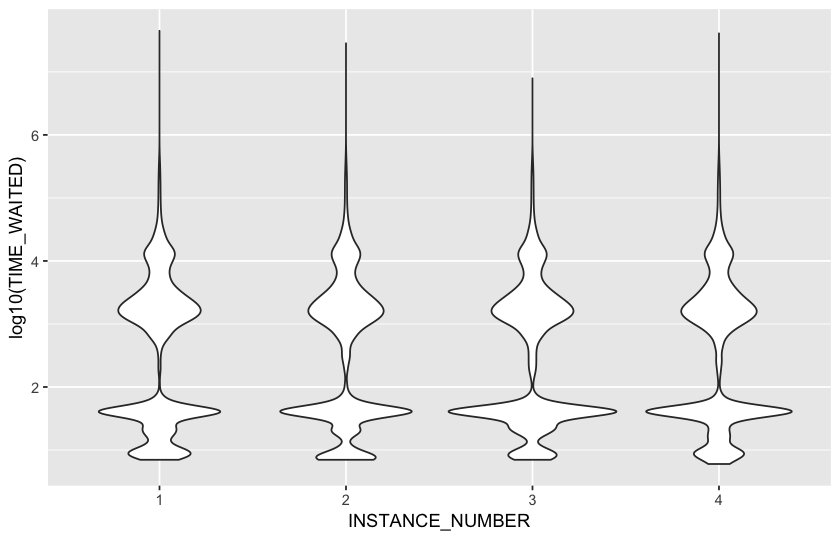

In [20]:
ggplot( data = Events
      , aes( x = INSTANCE_NUMBER, y = log10(TIME_WAITED) ) ) +
  geom_violin( aes( weight = EST_COUNT ) )

There are some subtle differences in the violin plots, especially in the lower latency region. Not sure what to make of it, probably not much.

Let's do a side-by-side comparison of sample count to estimated count densities using violin plots.

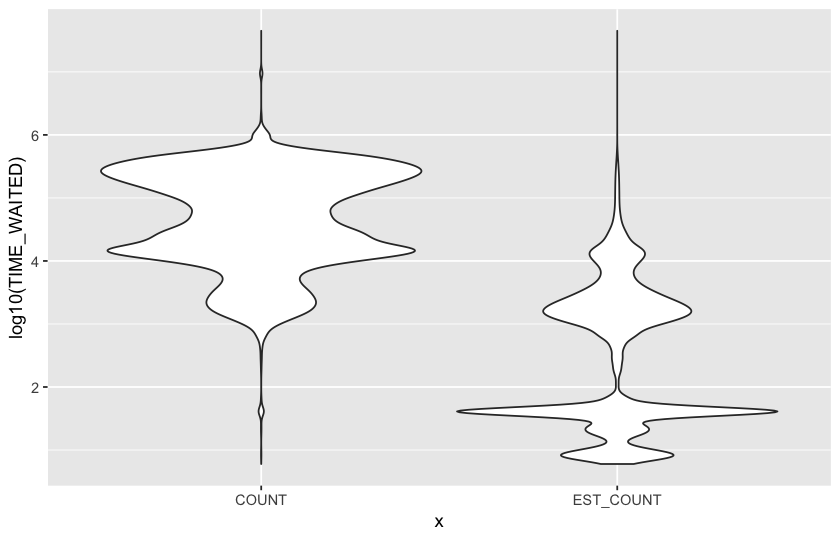

In [21]:
ggplot(data=Events, aes(x="COUNT", y=log10(TIME_WAITED))) +
  geom_violin() +
  geom_violin(aes(x="EST_COUNT", weight=EST_COUNT/sum(EST_COUNT)))

Finally, let's plot both violins on same x value using blue color fill for sampled and red for estimated occurrence densities. Since the densities overlap alpha is set to 0.5 for mutual see-through. This has the added visualization feature of showing the intersection of the two densities very visible.

Whether the intersection area has any real meaning is not obvious (to me) tbough.

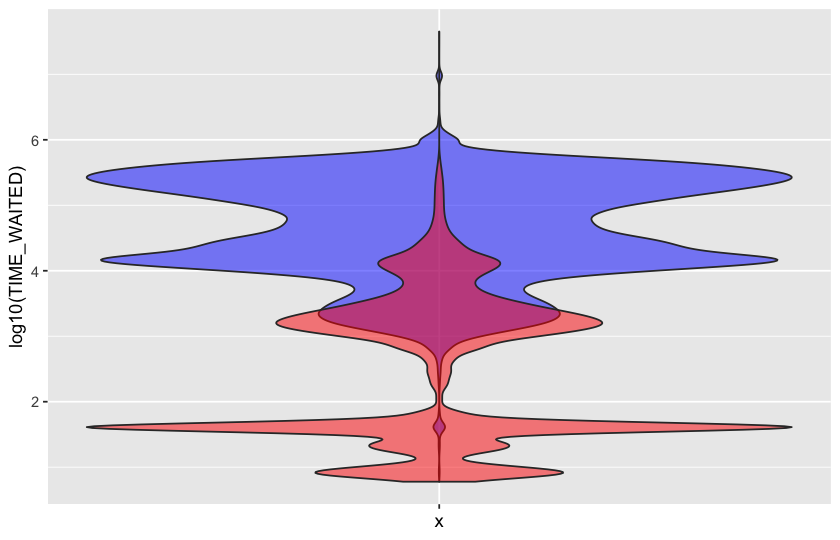

In [22]:
ggplot(data=Events, aes(x="1", y=log10(TIME_WAITED))) +
  geom_violin(aes(fill=I("blue")), alpha=.5) +
  geom_violin(aes(x="1", weight=EST_COUNT/sum(EST_COUNT), 
                  fill=I("red")),alpha=.5) +
  scale_x_discrete(labels=NULL)

## Conclusions
This episode was about looking at visual characterizations of the distribution of ASH dump sampled event latencies, starting with workmanlike box-whisker plots and moving on to density plots and finally playing the violins.

The ASH sampler is biased in the latency domain, so the samples in an ASH dump present a skewed view of the actual distribution of event latencies. We showed how to correct for this skew using the `EST_COUNT` variable to provide weighting factors for the density and violin plots.

The estimated event counts indicate the possibility of significant activity at quite low latencies, less than 100 microseconds. Given that Linux OS scheduler runs on a 10 millisecond timer (1) this means(?) that when the system is CPU-saturated these low latency events could blow up to 100x their normal latency. So finding out what these events are and how frequently they are really happening might be good preparation. `V$EVENT_HISTOGRAM` diffs could be useful in that regard.


## Learnings
-  estimating event counts from ASH samples
-  `geom_boxplot( )`
-  `geom_density( )`
-  `geom_violin( )`
-  `coord_flip( )`

## References
1. Scheduling in Linux, https://www.cs.montana.edu/~chandrima.sarkar/AdvancedOS/CSCI560_Proj_main/index.html